In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


Train and Test DataLoader

In [2]:
# define the train and test dataLoader
batch_size=128
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_transforms = transforms.Compose([
                                transforms.RandomAffine(degrees=3, translate=(0.1,0.1), scale=(0.9,1.1)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                              ])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                              ])

# train Loader
train_loader = torch.utils.data.DataLoader(datasets.MNIST("../data", train=True, download=True, 
                                            transform = train_transforms),batch_size=batch_size, shuffle=True, **kwargs)

#test Loader
test_loader = torch.utils.data.DataLoader(datasets.MNIST("../data", train=False, download=True, 
                                            transform = test_transforms),batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Model With BatchNorm

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.convolution1 = nn.Sequential(
        nn.Conv2d(1, 10, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Conv2d(10, 20, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.15)
    )
    self.convolution2 = nn.Sequential(
        nn.Conv2d(20, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 12, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.15)
    )
    self.convolution3 = nn.Sequential(
        nn.Conv2d(12, 12, 3),
        nn.Conv2d(12, 10, 3),
        nn.Conv2d(10, 10, 3)
        # nn.ReLU(),
        # nn.Conv2d(16, 10, 3),
    )
  def forward(self, x):
    x = self.convolution1(x)
    x = self.convolution2(x)
    x = self.convolution3(x)
    x = x.view(-1,10)
    return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 20, 28, 28]           1,820
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
         MaxPool2d-7           [-1, 20, 14, 14]               0
           Dropout-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,896
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 12, 14, 14]           1,740
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


GhostBatchNorm Class

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

Model With GhostBatchNorm

In [6]:
class GhostBatchNet(nn.Module):
  def __init__(self):
    super(GhostBatchNet, self).__init__()
    self.convolution1 = nn.Sequential(
        nn.Conv2d(1, 10, 3, padding=1),
        nn.ReLU(),
        GhostBatchNorm(10, num_splits=4),
        nn.Conv2d(10, 20, 3, padding=1),
        nn.ReLU(),
        GhostBatchNorm(20, num_splits=4),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.15)
    )
    self.convolution2 = nn.Sequential(
        nn.Conv2d(20, 16, 3, padding=1),
        nn.ReLU(),
        GhostBatchNorm(16, num_splits=4),
        nn.Conv2d(16, 12, 3, padding=1),
        nn.ReLU(),
        GhostBatchNorm(12, num_splits=4),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.15)
    )
    self.convolution3 = nn.Sequential(
        nn.Conv2d(12, 12, 3),
        nn.Conv2d(12, 10, 3),
        nn.Conv2d(10, 10, 3)
       
    )
  def forward(self, x):
    x = self.convolution1(x)
    x = self.convolution2(x)
    x = self.convolution3(x)
    x = x.view(-1,10)
    return F.log_softmax(x)

In [7]:
torch.manual_seed(1)

Define Test and Train which appends and returns the loss,accuracy to plot

In [8]:
from tqdm import tqdm

In [9]:
# out_train_acc=[]
# out_train_loss=[]
# out_val_acc=[]
# out_val_loss=[]
prev_val_acc=0.0

In [10]:
def train(model, device, train_loader, optimizer, epoch, i):
    model.train()
    correct=0
    processed=0
    pbar = tqdm(train_loader)
    train_l=0
    train_a=0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #train_l = loss
        if i == 2 or i == 3 or i == 6 or i == 7: #L1 Regularization is asked
          #print("i ",i)
          #loss_l1 = nn.L1Loss(target)
          # loss_ = 0
          # lambda_ = 0.005
          # lambda_ = 0.0005
          lambda_ = 0.0001
          l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])
          loss = loss + lambda_ * l1_reg_loss
        train_l = loss
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_a = (100*correct/processed)
    scheduler.step()
    return (train_l, train_a)


def test(model, device, test_loader, i):
    global prev_val_acc
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    val_acc = correct / len(test_loader.dataset)
    if i == 0 or i == 1:
      if (val_acc > prev_val_acc):
        prev_val_acc = val_acc
        torch.save(model, './{}'.format('model'+str(i)+'.pth'))
    return (test_loss, val_acc)

In [11]:
out_train_acc = {}
out_train_loss = {}
out_val_acc = {}
out_val_loss = {}
total_epochs = {}

for i in range(0,8):
  #global prev_val_acc
  print("i ",i)
  total_epochs[i] = []
  out_train_acc[i] = []
  out_train_loss[i] = []
  out_val_acc[i] = []
  out_val_loss[i] = []
  prev_val_acc = 0
  if i == 0: #without L1/L2 with BN
    print("without L1/L2 with BN")
    model = Net().to(device)

  if i == 1: #without L1/L2 with GBN
    print("without L1/L2 with GBN")
    model = GhostBatchNet().to(device)

  if i == 2: #with L1 with BN
    print("with L1 with BN")
    model = Net().to(device)

  if i == 3: #with L1 with GBN
    print("with L1 with GBN")
    model = GhostBatchNet().to(device)

  if i == 4: #with L2 with BN
    print("with L2 with BN")
    model = Net().to(device)

  if i == 5: #with L2 with GBN
    print("with L2 with GBN")
    model = GhostBatchNet().to(device)

  if i == 6: #with L1 and L2 with BN
    print("with L1 and L2 with BN")
    model = Net().to(device)

  if i == 7: #with L1 and L2 with GBN
    print("with L1 and L2 with GBN")
    model = GhostBatchNet().to(device)

  if (i == 0 or i==1 or i==2 or i==3):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  
  if (i == 4 or i == 5 or i == 6 or i == 7):
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,13], gamma=0.2)
  for epoch in range(0, 25):
    print (f"epoch : {epoch}")
    total_epochs[i].append(epoch)
    (out_train_loss_, out_train_acc_) = train(model, device, train_loader, optimizer, epoch, i)
    out_train_acc[i].append(out_train_acc_)
    out_train_loss[i].append(out_train_loss_)

    (out_val_loss_, out_val_acc_) = test(model, device, test_loader, i)
    out_val_acc[i].append(out_val_acc_)
    out_val_loss[i].append(out_val_loss_)


i  0
without L1/L2 with BN
epoch : 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.20405924320220947 batch_id=468 Accuracy=89.24166666666666: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]



Test set: Average loss: 0.0633, Accuracy: 9791/10000 (98%)

epoch : 1


loss=0.07153145223855972 batch_id=468 Accuracy=96.12833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0441, Accuracy: 9843/10000 (98%)

epoch : 2


loss=0.06049203500151634 batch_id=468 Accuracy=96.95666666666666: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0429, Accuracy: 9857/10000 (99%)

epoch : 3


loss=0.15219657123088837 batch_id=468 Accuracy=97.46666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]



Test set: Average loss: 0.0353, Accuracy: 9889/10000 (99%)

epoch : 4


loss=0.01838327758014202 batch_id=468 Accuracy=97.60166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.0306, Accuracy: 9897/10000 (99%)

epoch : 5


loss=0.15451094508171082 batch_id=468 Accuracy=97.85666666666667: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99%)

epoch : 6


loss=0.014998921193182468 batch_id=468 Accuracy=97.98166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]



Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99%)

epoch : 7


loss=0.05612519755959511 batch_id=468 Accuracy=98.005: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99%)

epoch : 8


loss=0.03483537584543228 batch_id=468 Accuracy=98.115: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0300, Accuracy: 9899/10000 (99%)

epoch : 9


loss=0.024781398475170135 batch_id=468 Accuracy=98.20166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99%)

epoch : 10


loss=0.026004048064351082 batch_id=468 Accuracy=98.56833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0179, Accuracy: 9939/10000 (99%)

epoch : 11


loss=0.0151777109131217 batch_id=468 Accuracy=98.62833333333333: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]



Test set: Average loss: 0.0177, Accuracy: 9935/10000 (99%)

epoch : 12


loss=0.06724406033754349 batch_id=468 Accuracy=98.735: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0190, Accuracy: 9932/10000 (99%)

epoch : 13


loss=0.044377535581588745 batch_id=468 Accuracy=98.73333333333333: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0174, Accuracy: 9936/10000 (99%)

epoch : 14


loss=0.03226860240101814 batch_id=468 Accuracy=98.695: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0171, Accuracy: 9937/10000 (99%)

epoch : 15


loss=0.03261959180235863 batch_id=468 Accuracy=98.76666666666667: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0166, Accuracy: 9942/10000 (99%)

epoch : 16


loss=0.04835592210292816 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]



Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99%)

epoch : 17


loss=0.033661145716905594 batch_id=468 Accuracy=98.78166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0164, Accuracy: 9941/10000 (99%)

epoch : 18


loss=0.010056653060019016 batch_id=468 Accuracy=98.82166666666667: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]



Test set: Average loss: 0.0165, Accuracy: 9939/10000 (99%)

epoch : 19


loss=0.03651534765958786 batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99%)

epoch : 20


loss=0.009200959466397762 batch_id=468 Accuracy=98.76166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 0.0165, Accuracy: 9941/10000 (99%)

epoch : 21


loss=0.02744355984032154 batch_id=468 Accuracy=98.70333333333333: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0164, Accuracy: 9943/10000 (99%)

epoch : 22


loss=0.010801197029650211 batch_id=468 Accuracy=98.815: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]



Test set: Average loss: 0.0165, Accuracy: 9940/10000 (99%)

epoch : 23


loss=0.12306156009435654 batch_id=468 Accuracy=98.76833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99%)

epoch : 24


loss=0.006007721181958914 batch_id=468 Accuracy=98.76166666666667: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.0167, Accuracy: 9939/10000 (99%)

i  1
without L1/L2 with GBN
epoch : 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.16466230154037476 batch_id=468 Accuracy=88.1: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0683, Accuracy: 9777/10000 (98%)

epoch : 1


loss=0.09333640336990356 batch_id=468 Accuracy=95.82333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0406, Accuracy: 9868/10000 (99%)

epoch : 2


loss=0.15567071735858917 batch_id=468 Accuracy=96.60166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0439, Accuracy: 9870/10000 (99%)

epoch : 3


loss=0.14840580523014069 batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]



Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99%)

epoch : 4


loss=0.05908478423953056 batch_id=468 Accuracy=97.58333333333333: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99%)

epoch : 5


loss=0.088352732360363 batch_id=468 Accuracy=97.72333333333333: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0313, Accuracy: 9901/10000 (99%)

epoch : 6


loss=0.05703454837203026 batch_id=468 Accuracy=97.71666666666667: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99%)

epoch : 7


loss=0.04615398868918419 batch_id=468 Accuracy=97.94166666666666: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99%)

epoch : 8


loss=0.08785536140203476 batch_id=468 Accuracy=98.00166666666667: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99%)

epoch : 9


loss=0.1070098876953125 batch_id=468 Accuracy=98.09833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0254, Accuracy: 9904/10000 (99%)

epoch : 10


loss=0.023116352036595345 batch_id=468 Accuracy=98.485: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]



Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99%)

epoch : 11


loss=0.04657101258635521 batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]



Test set: Average loss: 0.0165, Accuracy: 9939/10000 (99%)

epoch : 12


loss=0.007684953045099974 batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99%)

epoch : 13


loss=0.10410333424806595 batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0160, Accuracy: 9950/10000 (100%)

epoch : 14


loss=0.009625487960875034 batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0157, Accuracy: 9948/10000 (99%)

epoch : 15


loss=0.09044892340898514 batch_id=468 Accuracy=98.585: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]



Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99%)

epoch : 16


loss=0.031853485852479935 batch_id=468 Accuracy=98.67666666666666: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99%)

epoch : 17


loss=0.0061988490633666515 batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0152, Accuracy: 9947/10000 (99%)

epoch : 18


loss=0.007648281287401915 batch_id=468 Accuracy=98.71166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99%)

epoch : 19


loss=0.027313729748129845 batch_id=468 Accuracy=98.695: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0152, Accuracy: 9952/10000 (100%)

epoch : 20


loss=0.010196044109761715 batch_id=468 Accuracy=98.70166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]



Test set: Average loss: 0.0151, Accuracy: 9952/10000 (100%)

epoch : 21


loss=0.017353298142552376 batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.0153, Accuracy: 9948/10000 (99%)

epoch : 22


loss=0.0336335189640522 batch_id=468 Accuracy=98.665: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.0151, Accuracy: 9949/10000 (99%)

epoch : 23


loss=0.04561696946620941 batch_id=468 Accuracy=98.67333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]



Test set: Average loss: 0.0150, Accuracy: 9951/10000 (100%)

epoch : 24


loss=0.016920659691095352 batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]



Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99%)

i  2
with L1 with BN
epoch : 0


loss=0.13226403295993805 batch_id=468 Accuracy=88.60166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]



Test set: Average loss: 0.0503, Accuracy: 9834/10000 (98%)

epoch : 1


loss=0.1471603661775589 batch_id=468 Accuracy=96.17333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 0.0414, Accuracy: 9855/10000 (99%)

epoch : 2


loss=0.10590119659900665 batch_id=468 Accuracy=97.00666666666666: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0351, Accuracy: 9890/10000 (99%)

epoch : 3


loss=0.15315721929073334 batch_id=468 Accuracy=97.32833333333333: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0347, Accuracy: 9890/10000 (99%)

epoch : 4


loss=0.1516028493642807 batch_id=468 Accuracy=97.585: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0250, Accuracy: 9911/10000 (99%)

epoch : 5


loss=0.1156337633728981 batch_id=468 Accuracy=97.77333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]



Test set: Average loss: 0.0321, Accuracy: 9892/10000 (99%)

epoch : 6


loss=0.11051161587238312 batch_id=468 Accuracy=97.825: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99%)

epoch : 7


loss=0.09607240557670593 batch_id=468 Accuracy=97.97666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0255, Accuracy: 9915/10000 (99%)

epoch : 8


loss=0.06534207612276077 batch_id=468 Accuracy=98.05666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99%)

epoch : 9


loss=0.08299198001623154 batch_id=468 Accuracy=98.02166666666666: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.0224, Accuracy: 9917/10000 (99%)

epoch : 10


loss=0.06800004839897156 batch_id=468 Accuracy=98.57833333333333: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]



Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99%)

epoch : 11


loss=0.07369852811098099 batch_id=468 Accuracy=98.64666666666666: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99%)

epoch : 12


loss=0.08538024127483368 batch_id=468 Accuracy=98.68166666666667: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]



Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99%)

epoch : 13


loss=0.057714708149433136 batch_id=468 Accuracy=98.795: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]



Test set: Average loss: 0.0166, Accuracy: 9951/10000 (100%)

epoch : 14


loss=0.10455748438835144 batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]



Test set: Average loss: 0.0163, Accuracy: 9950/10000 (100%)

epoch : 15


loss=0.21204304695129395 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]



Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99%)

epoch : 16


loss=0.08333742618560791 batch_id=468 Accuracy=98.80333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0162, Accuracy: 9943/10000 (99%)

epoch : 17


loss=0.08066990971565247 batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]



Test set: Average loss: 0.0158, Accuracy: 9944/10000 (99%)

epoch : 18


loss=0.06290894001722336 batch_id=468 Accuracy=98.77666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]



Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99%)

epoch : 19


loss=0.1269376426935196 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.33it/s]



Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99%)

epoch : 20


loss=0.07088197022676468 batch_id=468 Accuracy=98.76833333333333: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99%)

epoch : 21


loss=0.07766007632017136 batch_id=468 Accuracy=98.83333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]



Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99%)

epoch : 22


loss=0.07134528458118439 batch_id=468 Accuracy=98.80666666666667: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]



Test set: Average loss: 0.0159, Accuracy: 9950/10000 (100%)

epoch : 23


loss=0.06878027319908142 batch_id=468 Accuracy=98.83166666666666: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99%)

epoch : 24


loss=0.07444747537374496 batch_id=468 Accuracy=98.83166666666666: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]



Test set: Average loss: 0.0160, Accuracy: 9945/10000 (99%)

i  3
with L1 with GBN
epoch : 0


loss=0.17484918236732483 batch_id=468 Accuracy=88.595: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]



Test set: Average loss: 0.0477, Accuracy: 9852/10000 (99%)

epoch : 1


loss=0.11721597611904144 batch_id=468 Accuracy=96.01333333333334: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0364, Accuracy: 9881/10000 (99%)

epoch : 2


loss=0.12731391191482544 batch_id=468 Accuracy=96.96833333333333: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0319, Accuracy: 9904/10000 (99%)

epoch : 3


loss=0.0873059332370758 batch_id=468 Accuracy=97.33666666666667: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.0289, Accuracy: 9901/10000 (99%)

epoch : 4


loss=0.08388928323984146 batch_id=468 Accuracy=97.44333333333333: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]



Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99%)

epoch : 5


loss=0.13612504303455353 batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99%)

epoch : 6


loss=0.11022484302520752 batch_id=468 Accuracy=97.895: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.0268, Accuracy: 9908/10000 (99%)

epoch : 7


loss=0.1509908139705658 batch_id=468 Accuracy=97.95166666666667: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]



Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99%)

epoch : 8


loss=0.25196436047554016 batch_id=468 Accuracy=98.005: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]



Test set: Average loss: 0.0272, Accuracy: 9912/10000 (99%)

epoch : 9


loss=0.11499956995248795 batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99%)

epoch : 10


loss=0.0736154317855835 batch_id=468 Accuracy=98.44666666666667: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99%)

epoch : 11


loss=0.08597048372030258 batch_id=468 Accuracy=98.55666666666667: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]



Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99%)

epoch : 12


loss=0.06777696311473846 batch_id=468 Accuracy=98.57666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99%)

epoch : 13


loss=0.07263214141130447 batch_id=468 Accuracy=98.665: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99%)

epoch : 14


loss=0.11733169853687286 batch_id=468 Accuracy=98.64166666666667: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99%)

epoch : 15


loss=0.10057825595140457 batch_id=468 Accuracy=98.67333333333333: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99%)

epoch : 16


loss=0.1217784434556961 batch_id=468 Accuracy=98.74666666666667: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99%)

epoch : 17


loss=0.11059132218360901 batch_id=468 Accuracy=98.61333333333333: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99%)

epoch : 18


loss=0.07948360592126846 batch_id=468 Accuracy=98.72333333333333: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99%)

epoch : 19


loss=0.06183494254946709 batch_id=468 Accuracy=98.83666666666667: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99%)

epoch : 20


loss=0.09049995988607407 batch_id=468 Accuracy=98.71166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99%)

epoch : 21


loss=0.09789919853210449 batch_id=468 Accuracy=98.64166666666667: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99%)

epoch : 22


loss=0.07201366126537323 batch_id=468 Accuracy=98.73833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99%)

epoch : 23


loss=0.1655152142047882 batch_id=468 Accuracy=98.72166666666666: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]



Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99%)

epoch : 24


loss=0.09450803697109222 batch_id=468 Accuracy=98.79333333333334: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99%)

i  4
with L2 with BN
epoch : 0


loss=0.23733948171138763 batch_id=468 Accuracy=88.685: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]



Test set: Average loss: 0.0731, Accuracy: 9778/10000 (98%)

epoch : 1


loss=0.06844905763864517 batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0549, Accuracy: 9827/10000 (98%)

epoch : 2


loss=0.2441566437482834 batch_id=468 Accuracy=97.10166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0354, Accuracy: 9892/10000 (99%)

epoch : 3


loss=0.0630745217204094 batch_id=468 Accuracy=97.43333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]



Test set: Average loss: 0.0310, Accuracy: 9896/10000 (99%)

epoch : 4


loss=0.07065566629171371 batch_id=468 Accuracy=97.62333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0320, Accuracy: 9901/10000 (99%)

epoch : 5


loss=0.04463654384016991 batch_id=468 Accuracy=97.77333333333333: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0244, Accuracy: 9906/10000 (99%)

epoch : 6


loss=0.03460334241390228 batch_id=468 Accuracy=98.01666666666667: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]



Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99%)

epoch : 7


loss=0.010833227075636387 batch_id=468 Accuracy=98.08166666666666: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]



Test set: Average loss: 0.0261, Accuracy: 9906/10000 (99%)

epoch : 8


loss=0.060442179441452026 batch_id=468 Accuracy=98.17666666666666: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]



Test set: Average loss: 0.0306, Accuracy: 9897/10000 (99%)

epoch : 9


loss=0.022751273587346077 batch_id=468 Accuracy=98.23666666666666: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99%)

epoch : 10


loss=0.08813875168561935 batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99%)

epoch : 11


loss=0.04498342052102089 batch_id=468 Accuracy=98.64833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99%)

epoch : 12


loss=0.046873774379491806 batch_id=468 Accuracy=98.64666666666666: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99%)

epoch : 13


loss=0.014019417576491833 batch_id=468 Accuracy=98.75833333333334: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99%)

epoch : 14


loss=0.02591695450246334 batch_id=468 Accuracy=98.78166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99%)

epoch : 15


loss=0.15030287206172943 batch_id=468 Accuracy=98.79333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99%)

epoch : 16


loss=0.036024898290634155 batch_id=468 Accuracy=98.78833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99%)

epoch : 17


loss=0.041959166526794434 batch_id=468 Accuracy=98.765: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99%)

epoch : 18


loss=0.0537223257124424 batch_id=468 Accuracy=98.78166666666667: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99%)

epoch : 19


loss=0.04299503564834595 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]



Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99%)

epoch : 20


loss=0.015997175127267838 batch_id=468 Accuracy=98.77166666666666: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99%)

epoch : 21


loss=0.018667638301849365 batch_id=468 Accuracy=98.82833333333333: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99%)

epoch : 22


loss=0.008810202591121197 batch_id=468 Accuracy=98.79666666666667: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99%)

epoch : 23


loss=0.11763692647218704 batch_id=468 Accuracy=98.745: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99%)

epoch : 24


loss=0.018447285518050194 batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99%)

i  5
with L2 with GBN
epoch : 0


loss=0.1401328295469284 batch_id=468 Accuracy=88.70833333333333: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0557, Accuracy: 9822/10000 (98%)

epoch : 1


loss=0.15925456583499908 batch_id=468 Accuracy=96.24333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0373, Accuracy: 9879/10000 (99%)

epoch : 2


loss=0.08843610435724258 batch_id=468 Accuracy=96.98166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 0.0409, Accuracy: 9875/10000 (99%)

epoch : 3


loss=0.14626097679138184 batch_id=468 Accuracy=97.29333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0373, Accuracy: 9870/10000 (99%)

epoch : 4


loss=0.07369920611381531 batch_id=468 Accuracy=97.605: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0281, Accuracy: 9905/10000 (99%)

epoch : 5


loss=0.03756129369139671 batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0329, Accuracy: 9892/10000 (99%)

epoch : 6


loss=0.07735408842563629 batch_id=468 Accuracy=97.79666666666667: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99%)

epoch : 7


loss=0.04174909368157387 batch_id=468 Accuracy=97.945: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0293, Accuracy: 9903/10000 (99%)

epoch : 8


loss=0.03508290275931358 batch_id=468 Accuracy=98.025: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99%)

epoch : 9


loss=0.026339324191212654 batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]



Test set: Average loss: 0.0311, Accuracy: 9909/10000 (99%)

epoch : 10


loss=0.016932649537920952 batch_id=468 Accuracy=98.46666666666667: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99%)

epoch : 11


loss=0.01001454796642065 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]



Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99%)

epoch : 12


loss=0.01031322218477726 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99%)

epoch : 13


loss=0.03537899628281593 batch_id=468 Accuracy=98.62166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99%)

epoch : 14


loss=0.06463300436735153 batch_id=468 Accuracy=98.72166666666666: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99%)

epoch : 15


loss=0.04109274968504906 batch_id=468 Accuracy=98.765: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]



Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99%)

epoch : 16


loss=0.02940347231924534 batch_id=468 Accuracy=98.685: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99%)

epoch : 17


loss=0.04911331459879875 batch_id=468 Accuracy=98.665: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]



Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99%)

epoch : 18


loss=0.02490498311817646 batch_id=468 Accuracy=98.68333333333334: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99%)

epoch : 19


loss=0.05802777409553528 batch_id=468 Accuracy=98.735: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]



Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99%)

epoch : 20


loss=0.08412081748247147 batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]



Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99%)

epoch : 21


loss=0.07531117647886276 batch_id=468 Accuracy=98.695: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]



Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99%)

epoch : 22


loss=0.1741132140159607 batch_id=468 Accuracy=98.68666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99%)

epoch : 23


loss=0.05373452976346016 batch_id=468 Accuracy=98.75666666666666: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99%)

epoch : 24


loss=0.030840305611491203 batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99%)

i  6
with L1 and L2 with BN
epoch : 0


loss=0.13480696082115173 batch_id=468 Accuracy=89.52833333333334: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]



Test set: Average loss: 0.0676, Accuracy: 9773/10000 (98%)

epoch : 1


loss=0.12161895632743835 batch_id=468 Accuracy=96.52333333333333: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]



Test set: Average loss: 0.0377, Accuracy: 9872/10000 (99%)

epoch : 2


loss=0.16387058794498444 batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0434, Accuracy: 9856/10000 (99%)

epoch : 3


loss=0.1477903127670288 batch_id=468 Accuracy=97.38166666666666: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]



Test set: Average loss: 0.0332, Accuracy: 9879/10000 (99%)

epoch : 4


loss=0.20101356506347656 batch_id=468 Accuracy=97.7: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]



Test set: Average loss: 0.0357, Accuracy: 9879/10000 (99%)

epoch : 5


loss=0.1052430048584938 batch_id=468 Accuracy=97.74833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]



Test set: Average loss: 0.0310, Accuracy: 9887/10000 (99%)

epoch : 6


loss=0.16666194796562195 batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]



Test set: Average loss: 0.0302, Accuracy: 9893/10000 (99%)

epoch : 7


loss=0.15760929882526398 batch_id=468 Accuracy=97.97833333333334: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99%)

epoch : 8


loss=0.09572331607341766 batch_id=468 Accuracy=97.92333333333333: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99%)

epoch : 9


loss=0.149041086435318 batch_id=468 Accuracy=98.08666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]



Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99%)

epoch : 10


loss=0.119191974401474 batch_id=468 Accuracy=98.575: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99%)

epoch : 11


loss=0.12678691744804382 batch_id=468 Accuracy=98.60833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99%)

epoch : 12


loss=0.05823872983455658 batch_id=468 Accuracy=98.62833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99%)

epoch : 13


loss=0.06470230221748352 batch_id=468 Accuracy=98.735: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]



Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99%)

epoch : 14


loss=0.10617919266223907 batch_id=468 Accuracy=98.74833333333333: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99%)

epoch : 15


loss=0.08547617495059967 batch_id=468 Accuracy=98.82833333333333: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]



Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99%)

epoch : 16


loss=0.06058063358068466 batch_id=468 Accuracy=98.775: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99%)

epoch : 17


loss=0.07790862768888474 batch_id=468 Accuracy=98.82333333333334: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99%)

epoch : 18


loss=0.09446734189987183 batch_id=468 Accuracy=98.78833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99%)

epoch : 19


loss=0.07612194865942001 batch_id=468 Accuracy=98.785: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99%)

epoch : 20


loss=0.12319250404834747 batch_id=468 Accuracy=98.77333333333333: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0165, Accuracy: 9950/10000 (100%)

epoch : 21


loss=0.09263519197702408 batch_id=468 Accuracy=98.80666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0161, Accuracy: 9946/10000 (99%)

epoch : 22


loss=0.0764646828174591 batch_id=468 Accuracy=98.76166666666667: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]



Test set: Average loss: 0.0161, Accuracy: 9946/10000 (99%)

epoch : 23


loss=0.07422564923763275 batch_id=468 Accuracy=98.81166666666667: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99%)

epoch : 24


loss=0.1216205283999443 batch_id=468 Accuracy=98.84833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]



Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99%)

i  7
with L1 and L2 with GBN
epoch : 0


loss=0.17141611874103546 batch_id=468 Accuracy=88.52: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0561, Accuracy: 9818/10000 (98%)

epoch : 1


loss=0.07770565152168274 batch_id=468 Accuracy=96.31833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0416, Accuracy: 9863/10000 (99%)

epoch : 2


loss=0.1702890545129776 batch_id=468 Accuracy=96.98833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0342, Accuracy: 9885/10000 (99%)

epoch : 3


loss=0.1733514964580536 batch_id=468 Accuracy=97.37833333333333: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0353, Accuracy: 9884/10000 (99%)

epoch : 4


loss=0.10651369392871857 batch_id=468 Accuracy=97.47833333333334: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]



Test set: Average loss: 0.0308, Accuracy: 9895/10000 (99%)

epoch : 5


loss=0.11297202110290527 batch_id=468 Accuracy=97.65666666666667: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99%)

epoch : 6


loss=0.09867929667234421 batch_id=468 Accuracy=97.785: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0369, Accuracy: 9876/10000 (99%)

epoch : 7


loss=0.1477898210287094 batch_id=468 Accuracy=97.87833333333333: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]



Test set: Average loss: 0.0296, Accuracy: 9893/10000 (99%)

epoch : 8


loss=0.23569686710834503 batch_id=468 Accuracy=97.91833333333334: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0249, Accuracy: 9918/10000 (99%)

epoch : 9


loss=0.0985608696937561 batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0278, Accuracy: 9908/10000 (99%)

epoch : 10


loss=0.06543590128421783 batch_id=468 Accuracy=98.435: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0185, Accuracy: 9945/10000 (99%)

epoch : 11


loss=0.09851479530334473 batch_id=468 Accuracy=98.525: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99%)

epoch : 12


loss=0.09676391631364822 batch_id=468 Accuracy=98.59666666666666: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]



Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99%)

epoch : 13


loss=0.16744399070739746 batch_id=468 Accuracy=98.63833333333334: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99%)

epoch : 14


loss=0.09284965693950653 batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]



Test set: Average loss: 0.0161, Accuracy: 9952/10000 (100%)

epoch : 15


loss=0.07707658410072327 batch_id=468 Accuracy=98.73666666666666: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0157, Accuracy: 9945/10000 (99%)

epoch : 16


loss=0.08277980238199234 batch_id=468 Accuracy=98.73666666666666: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0156, Accuracy: 9949/10000 (99%)

epoch : 17


loss=0.06161987781524658 batch_id=468 Accuracy=98.77166666666666: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]



Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99%)

epoch : 18


loss=0.1494012475013733 batch_id=468 Accuracy=98.74166666666666: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]



Test set: Average loss: 0.0154, Accuracy: 9948/10000 (99%)

epoch : 19


loss=0.16716206073760986 batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0157, Accuracy: 9947/10000 (99%)

epoch : 20


loss=0.098199263215065 batch_id=468 Accuracy=98.77166666666666: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0155, Accuracy: 9952/10000 (100%)

epoch : 21


loss=0.16546691954135895 batch_id=468 Accuracy=98.685: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0158, Accuracy: 9947/10000 (99%)

epoch : 22


loss=0.12493692338466644 batch_id=468 Accuracy=98.75666666666666: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99%)

epoch : 23


loss=0.10616466403007507 batch_id=468 Accuracy=98.63166666666666: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]



Test set: Average loss: 0.0155, Accuracy: 9950/10000 (100%)

epoch : 24


loss=0.13770107924938202 batch_id=468 Accuracy=98.71833333333333: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 0.0153, Accuracy: 9951/10000 (100%)



In [12]:
out_train_loss_val={}
for p in range (0,8):
  out_train_loss_val[p]=[]
  for item in out_train_loss[p]:
    out_train_loss_val[p].append(item.item())
for p in range (0,8):
  print(out_train_acc[p])
  print(out_train_loss_val[p])
  print(out_val_acc[p])
  print(out_val_loss[p])
  print(total_epochs[p])

[89.24166666666666, 96.12833333333333, 96.95666666666666, 97.46666666666667, 97.60166666666667, 97.85666666666667, 97.98166666666667, 98.005, 98.115, 98.20166666666667, 98.56833333333333, 98.62833333333333, 98.735, 98.73333333333333, 98.695, 98.76666666666667, 98.78, 98.78166666666667, 98.82166666666667, 98.76, 98.76166666666667, 98.70333333333333, 98.815, 98.76833333333333, 98.76166666666667]
[0.20405924320220947, 0.07153145223855972, 0.06049203500151634, 0.15219657123088837, 0.01838327758014202, 0.15451094508171082, 0.014998921193182468, 0.05612519755959511, 0.03483537584543228, 0.024781398475170135, 0.026004048064351082, 0.0151777109131217, 0.06724406033754349, 0.044377535581588745, 0.03226860240101814, 0.03261959180235863, 0.04835592210292816, 0.033661145716905594, 0.010056653060019016, 0.03651534765958786, 0.009200959466397762, 0.02744355984032154, 0.010801197029650211, 0.12306156009435654, 0.006007721181958914]
[0.9791, 0.9843, 0.9857, 0.9889, 0.9897, 0.9923, 0.9918, 0.9924, 0.98

In [13]:
Color=[]
Color.append('red')
Color.append('black')
Color.append('green')
Color.append('purple')
Color.append('cyan')
Color.append('yellow')
Color.append('brown')
Color.append('blue')

labels=[]
labels.append("!L1 !L2 with BN")
labels.append("!L1 !L2 with GBN")
labels.append("L1 with BN")
labels.append("L1 with GBN")
labels.append("L2 with BN")
labels.append("L2 with GBN")
labels.append("L1-L2 with BN")
labels.append("L1-L2 with GBN")

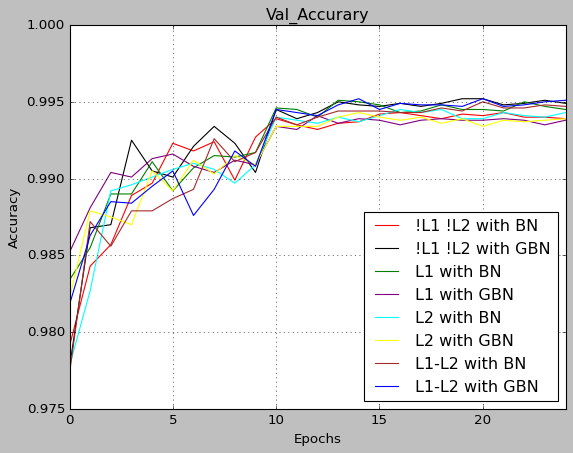

In [14]:
# #print(total_epochs)
# fig = plt.figure()
# ax0 = fig.add_subplot(111,title="val_accuray")
# ax0.set_ylabel("Accuracy")
# ax0.set_xlabel("Epochs")
# for t in range(0,8):
#     ax0.plot(total_epochs[t], out_val_acc[t], 'ro-', label='val_acc', color=Color[t])

plt.style.use('classic')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# fig, ax = plt.subplots()
plt.subplots_adjust(hspace=0.001)
plt.grid(True)
plt.title("Val_Accurary")
# plt.yticks([0.005, 0.01,0.015,0.02,0.04, 0.05,0.06,0.07,0.08, 0.09])
for t in range(0,8):
    #ax0.plot(total_epochs[t], out_val_loss[t], 'ro-', label='test_loss', color=Color[t])
    plt.plot(total_epochs[t], out_val_acc[t], "-b", color=Color[t], label=labels[t])
    plt.legend(loc="lower right")
    # plt.ylim(0.01, 0.08)
    plt.xlim(0, 24)

In [15]:
# fig = plt.figure()
# ax0 = fig.add_subplot(111,title="train_loss")
# ax0.set_ylabel("Loss")
# ax0.set_xlabel("Epochs")
# for t in range(0,8):
#     ax0.plot(total_epochs[t], out_train_loss_val[t], 'ro-', label='train_loss', color=Color[t])

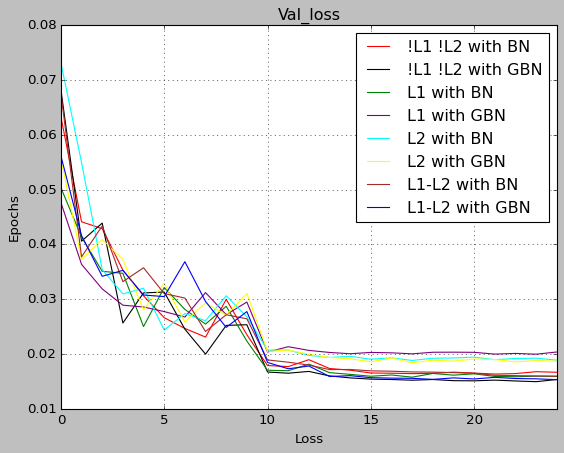

In [16]:
# fig = plt.figure()
# ax0 = fig.add_subplot(111,title="test_loss")
# ax0.set_ylabel("Loss")
# ax0.set_xlabel("Epochs")
# for t in range(0,8):
#     ax0.plot(total_epochs[t], out_val_loss[t], 'ro-', label='test_loss', color=Color[t])

plt.style.use('classic')
plt.xlabel("Loss")
plt.ylabel("Epochs")
# fig, ax = plt.subplots()
# plt.subplots_adjust(hspace=0.001)
plt.grid(True)
plt.title("Val_loss")
# plt.yticks([0.005, 0.01,0.015,0.02,0.04, 0.05,0.06,0.07,0.08, 0.09])
for t in range(0,8):
    #ax0.plot(total_epochs[t], out_val_loss[t], 'ro-', label='test_loss', color=Color[t])
    plt.plot(total_epochs[t], out_val_loss[t], "-b", color=Color[t], label=labels[t])
    plt.legend(loc="upper right")
    plt.ylim(0.01, 0.08)
    plt.xlim(0, 24)

Find Misclassified Images

In [17]:
def findMisclassifiedImages(model):
        misclassified = []
        misclassified_pred = []
        misclassified_target = []
        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                # move them to the respective device
                data, target = data.to(device), target.to(device)
                # do inferencing
                output = model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_pred = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]


                misclassified.append(batch_misclassified)
                misclassified_pred.append(batch_mis_pred)
                misclassified_target.append(batch_mis_target)

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_pred)
        misclassified_target = torch.cat(misclassified_target)

        return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))


In [18]:
model1 = torch.load("model0.pth")
model2 = torch.load("model1.pth")

out1_misclassified = findMisclassifiedImages(model1)
out2_misclassified = findMisclassifiedImages(model2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
import PIL
from PIL import Image

In [20]:
# transform = transforms.ToPILImage()
# img = transform(out1_misclassified[25][0])

In [21]:
# img.show()

In [22]:
# print(out1_misclassified[25][1])
# print(out1_misclassified[25][2])
!mkdir image_model1 image_model2

In [23]:
transform = transforms.ToPILImage()
from google.colab import files
# files.download("/content/test.txt")
for r in range(0,24):
  # transform = transforms.ToPILImage()
  img = transform(out1_misclassified[r][0])
  img2 = transform(out2_misclassified[r][0])
  draw = PIL.ImageDraw.Draw(img)
  draw2 = PIL.ImageDraw.Draw(img2)
  # print(out1_misclassified[r][1].item())
  # print(out1_misclassified[r][2])
  draw.text((0, 0), str(out1_misclassified[r][1].item()))
  draw2.text((0, 0), str(out2_misclassified[r][1].item()))
  draw.text((0, 20),str(out1_misclassified[r][2].item()))
  draw2.text((0, 20),str(out2_misclassified[r][2].item()))
  img.save("image_model1/"+str(r)+".jpg")
  img2.save("image_model2/"+str(r)+".jpg")
  # files.download("/content/image_model1/"+str(r)+".png")
  # files.download("/content/image_model2/"+str(r)+".png")

In [24]:
!zip -r image_model1.zip image_model1
!zip -r image_model2.zip image_model2

  adding: image_model1/ (stored 0%)
  adding: image_model1/18.jpg (stored 0%)
  adding: image_model1/13.jpg (stored 0%)
  adding: image_model1/22.jpg (stored 0%)
  adding: image_model1/6.jpg (stored 0%)
  adding: image_model1/5.jpg (stored 0%)
  adding: image_model1/4.jpg (stored 0%)
  adding: image_model1/19.jpg (stored 0%)
  adding: image_model1/0.jpg (stored 0%)
  adding: image_model1/11.jpg (stored 0%)
  adding: image_model1/9.jpg (stored 0%)
  adding: image_model1/20.jpg (stored 0%)
  adding: image_model1/1.jpg (stored 0%)
  adding: image_model1/10.jpg (stored 0%)
  adding: image_model1/8.jpg (stored 0%)
  adding: image_model1/17.jpg (stored 0%)
  adding: image_model1/23.jpg (stored 0%)
  adding: image_model1/15.jpg (stored 0%)
  adding: image_model1/16.jpg (stored 0%)
  adding: image_model1/7.jpg (stored 0%)
  adding: image_model1/2.jpg (stored 0%)
  adding: image_model1/21.jpg (stored 0%)
  adding: image_model1/3.jpg (stored 0%)
  adding: image_model1/14.jpg (stored 0%)
  adding

In [25]:
files.download("image_model1.zip")
files.download("image_model2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# !rm *.png

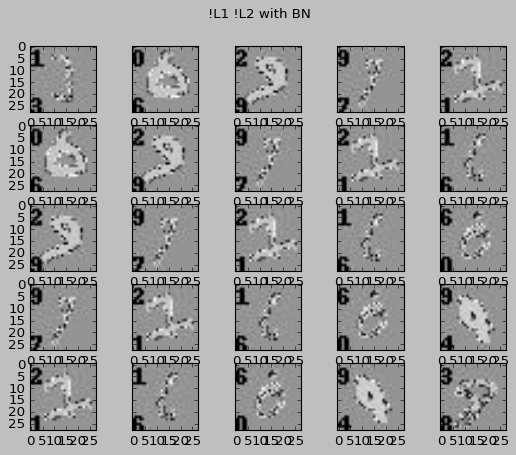

In [29]:
from PIL import Image
import cv2
f, axarr = plt.subplots(5,5,sharey=True)
plt.suptitle('!L1 !L2 with BN')
#top-left is prediction
#bottom-left is target
for i in range(0,5):
  for p in range(0,5):
    #img = Image.open("image_model1/"+str(i+p)+".jpg")
    img = cv2.imread("image_model1/"+str(i+p)+".jpg")
    axarr[i,p].imshow(img)

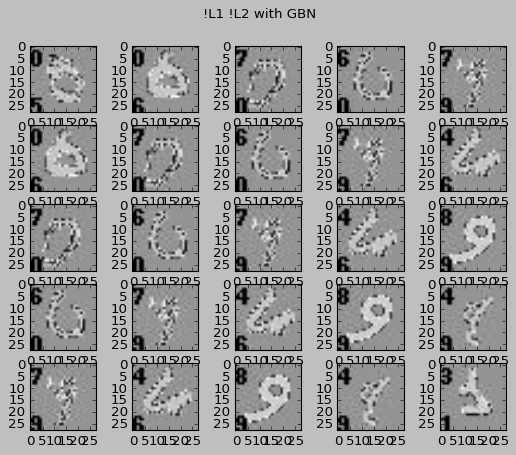

In [30]:
from PIL import Image
f, axarr = plt.subplots(5,5)
plt.suptitle('!L1 !L2 with GBN')
#top-left is prediction
#bottom-left is target
for i in range(0,5):
  for p in range(0,5):
    #img = Image.open("image_model2/"+str(i+p)+".jpg")
    img = cv2.imread("image_model2/"+str(i+p)+".jpg")
    axarr[i,p].imshow(img)
